In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Check available GPUs
physical_devices = tf.config.list_physical_devices('GPU')
print("Available GPUs:", physical_devices)

# Set memory growth for each GPU
if physical_devices:
    for gpu in physical_devices:
        tf.config.experimental.set_memory_growth(gpu, True)

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Loading Fruit-360: 131 Category Dataset into Train, Test, and Validation set

In [3]:
# Paths to your dataset directories
train_dir = '/kaggle/input/fruits/fruits-360_dataset/fruits-360/Training'
val_dir = '/kaggle/input/fruits/fruits-360_dataset/fruits-360/Test'

# Image dimensions and batch size
img_size = (100, 100)
batch_size = 32

# Create a data generator for training with augmentation and normalization
train_datagen = ImageDataGenerator(rescale=1./255)

# Load all data from validation directory
classes = os.listdir(val_dir)
file_paths = []
labels = []

for cls in classes:
    class_dir = os.path.join(val_dir, cls)
    if os.path.isdir(class_dir):
        for file_name in os.listdir(class_dir):
            file_paths.append(os.path.join(class_dir, file_name))
            labels.append(cls)

file_paths = np.array(file_paths)
labels = np.array(labels)

# Perform stratified split for validation and test sets (70% validation, 30% test)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    file_paths, labels, test_size=0.3, stratify=labels, random_state=42
)

# Create data generators
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

val_data_131 = val_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': val_paths, 'class': val_labels}),
    directory=None,
    x_col='filename',
    y_col='class',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_data_131 = test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': test_paths, 'class': test_labels}),
    directory=None,
    x_col='filename',
    y_col='class',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Convert to tf.data.Dataset for better performance
train_data_131 = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

train_ds_131 = tf.data.Dataset.from_generator(
    lambda: train_data_131,
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, img_size[0], img_size[1], 3], [None, len(train_data_131.class_indices)])
).repeat().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_ds_131 = tf.data.Dataset.from_generator(
    lambda: val_data_131,
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, img_size[0], img_size[1], 3], [None, len(val_data_131.class_indices)])
).repeat().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

test_ds_131 = tf.data.Dataset.from_generator(
    lambda: test_data_131,
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, img_size[0], img_size[1], 3], [None, len(test_data_131.class_indices)])
).repeat().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Print the number of samples in each set
print(f"\nTotal images: {train_data_131.samples+val_data_131.samples+test_data_131.samples}")
print(f"\nNumber of training samples: {train_data_131.samples}")
print(f"Number of validation samples: {val_data_131.samples}")
print(f"Number of test samples: {test_data_131.samples}")

Found 15881 validated image filenames belonging to 131 classes.
Found 6807 validated image filenames belonging to 131 classes.
Found 67692 images belonging to 131 classes.

Total images: 90380

Number of training samples: 67692
Number of validation samples: 15881
Number of test samples: 6807


In [4]:
# Get class names from the training data generator
class_names = list(train_data_131.class_indices.keys())
print()
print("Class names:", class_names)


Class names: ['Apple Braeburn', 'Apple Crimson Snow', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith', 'Apple Pink Lady', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apricot', 'Avocado', 'Avocado ripe', 'Banana', 'Banana Lady Finger', 'Banana Red', 'Beetroot', 'Blueberry', 'Cactus fruit', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cauliflower', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 'Cherry Wax Red', 'Cherry Wax Yellow', 'Chestnut', 'Clementine', 'Cocos', 'Corn', 'Corn Husk', 'Cucumber Ripe', 'Cucumber Ripe 2', 'Dates', 'Eggplant', 'Fig', 'Ginger Root', 'Granadilla', 'Grape Blue', 'Grape Pink', 'Grape White', 'Grape White 2', 'Grape White 3', 'Grape White 4', 'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Hazelnut', 'Huckleberry', 'Kaki', 'Kiwi', 'Kohlrabi', 'Kumquats', 'Lemon', 'Lemon Meyer', 'Limes', 'Lychee', 'Mandarine', 'Mango', 'Mango Red', 'Mangostan', 'Ma

### Loading train and test data of Fruit360: 131 category without split

In [21]:
# Image dimensions and batch size
img_size = (100, 100)
batch_size = 32

train_dir = '/kaggle/input/fruits/fruits-360_dataset/fruits-360/Training'
val_dir = '/kaggle/input/fruits/fruits-360_dataset/fruits-360/Test'

train_datagen = ImageDataGenerator(rescale=1./255)

val_datagen = ImageDataGenerator(rescale=1./255)

# Flow data from directories
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Convert to tf.data.Dataset for better performance
train_ds = tf.data.Dataset.from_generator(
    lambda: train_data,
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, img_size[0], img_size[1], 3], [None, len(train_data.class_indices)])
).repeat().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_ds = tf.data.Dataset.from_generator(
    lambda: val_data,
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, img_size[0], img_size[1], 3], [None, len(val_data.class_indices)])
).repeat().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

Found 67692 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


# My_learnable_weighted_skip_model

In [5]:
from tensorflow.keras import layers

# Defining the custom layer with registration
@tf.keras.utils.register_keras_serializable(package='Custom')
class WeightedSkipConnection(layers.Layer):
    def __init__(self, channels, **kwargs):
        super(WeightedSkipConnection, self).__init__(**kwargs)
        self.channels = channels
        self.learnable_weight = None

    def build(self, input_shape):
        self.learnable_weight = self.add_weight(
            shape=(1, 1, 1, self.channels),
            initializer=tf.keras.initializers.RandomUniform(minval=0, maxval=1),
            trainable=True
        )
        super(WeightedSkipConnection, self).build(input_shape)

    def call(self, inputs):
        x, skip = inputs
        weight = self.learnable_weight
        return x + (skip * weight)

    def get_config(self):
        config = super(WeightedSkipConnection, self).get_config()
        config.update({"channels": self.channels})
        return config

# Define the model architecture
def create_model(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)

    # First convolutional layer (Depthwise Separable)
    x = layers.SeparableConv2D(24, (3, 3), padding='same')(inputs)
    x = layers.ReLU()(x)

    # Saving the output for the first skip connection
    skip1 = x

    # Second convolutional layer with stride 2 (Depthwise Separable)
    x = layers.SeparableConv2D(24, (3, 3), strides=2, padding='same')(x)

    # Adjusting the dimensions of the skip connection to match the second layer
    skip1 = layers.MaxPooling2D(pool_size=(2, 2))(skip1)

    # Adding the first skip connection with weighted skip before ReLU
    x = WeightedSkipConnection(24)([x, skip1])
    x = layers.ReLU()(x)

    # Third convolutional layer (Depthwise Separable)
    x = layers.SeparableConv2D(48, (3, 3), padding='same')(x)
    x = layers.ReLU()(x)

    # Saving the output for the second skip connection
    skip2 = x

    # Fourth convolutional layer with stride 2 (Depthwise Separable)
    x = layers.SeparableConv2D(48, (3, 3), strides=2, padding='same')(x)

    # Adjusting the dimensions of the skip connection to match the fourth layer
    skip2 = layers.MaxPooling2D(pool_size=(2, 2))(skip2)

    # Adding the second skip connection with weighted skip before ReLU
    x = WeightedSkipConnection(48)([x, skip2])
    x = layers.ReLU()(x)

    # Fifth convolutional layer (Depthwise Separable)
    x = layers.SeparableConv2D(96, (3, 3), padding='same')(x)
    x = layers.ReLU()(x)

    # Saving the output for the third skip connection
    skip3 = x

    # Sixth convolutional layer (1x1)
    x = layers.Conv2D(96, (1, 1), padding='same')(x)

    # Add the third skip connection with weighted skip before ReLU
    x = WeightedSkipConnection(96)([x, skip3])
    x = layers.ReLU()(x)

    # Seventh convolutional layer (1x1)
    x = layers.Conv2D(131, (1, 1), padding='same')(x)

    # Global Average Pooling layer
    x = layers.GlobalAveragePooling2D()(x)

    # Output softmax layer
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Creating the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Creating an instance of the model
input_shape = (100, 100, 3)
num_classes = 131
my_weighted_skip_model = create_model(input_shape, num_classes)

# Compiling the model
my_weighted_skip_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
my_weighted_skip_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d    │ (None, 100, 100,  │        123 │ input_layer[0][0] │
│ (SeparableConv2D)   │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 100, 100,  │          0 │ separable_conv2d… │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1  │ (None, 50, 50,    │        816 │ re_lu[0][0]       │
│ (SeparableConv2D)   │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 50, 50,    │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ weighted_skip_conn… │ (None, 50, 50,    │         24 │ separable_conv2d… │
│ (WeightedSkipConne… │ 24)               │            │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 50, 50,    │          0 │ weighted_skip_co… │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_2  │ (None, 50, 50,    │      1,416 │ re_lu_1[0][0]     │
│ (SeparableConv2D)   │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 50, 50,    │          0 │ separable_conv2d… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_3  │ (None, 25, 25,    │      2,784 │ re_lu_2[0][0]     │
│ (SeparableConv2D)   │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 25, 25,    │          0 │ re_lu_2[0][0]     │
│ (MaxPooling2D)      │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ weighted_skip_conn… │ (None, 25, 25,    │         48 │ separable_conv2d… │
│ (WeightedSkipConne… │ 48)               │            │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 25, 25,    │          0 │ weighted_skip_co… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_4  │ (None, 25, 25,    │      5,136 │ re_lu_3[0][0]     │
│ (SeparableConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_4 (ReLU)      │ (None, 25, 25,    │          0 │ separable_conv2d… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 25, 25,    │      9,312 │ re_lu_4[0][0]     │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ weighted_skip_conn… │ (None, 25, 25,    │         96 │ conv2d[0][0],   

 Total params: 49,754 (194.35 KB)

 Trainable params: 49,754 (194.35 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
checkpoint = ModelCheckpoint(
    filepath='/kaggle/working/my_learnable_weighted_skip_131_v2.keras',
    monitor='val_accuracy',    
    save_best_only=True,       
    mode='max',                
    verbose=1                  
)

In [7]:
history = my_weighted_skip_model.fit(
    train_ds_131,
    epochs=50,
    steps_per_epoch=len(train_data_131),
    validation_data=val_ds_131,
    validation_steps=len(val_data_131),
    callbacks=[checkpoint]
)

Epoch 1/50
   1/2116 ━━━━━━━━━━━━━━━━━━━━ 5:49:54 10s/step - accuracy: 0.0000e+00 - loss: 4.8756

I0000 00:00:1719371814.998984      89 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2116/2116 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.2232 - loss: 3.2256
Epoch 1: val_accuracy improved from -inf to 0.64832, saving model to /kaggle/working/my_learnable_weighted_skip_131_v2.keras
2116/2116 ━━━━━━━━━━━━━━━━━━━━ 433s 200ms/step - accuracy: 0.2233 - loss: 3.2251 - val_accuracy: 0.6483 - val_loss: 1.2439
Epoch 2/50
2114/2116 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7624 - loss: 0.7363
Epoch 2: val_accuracy improved from 0.64832 to 0.73201, saving model to /kaggle/working/my_learnable_weighted_skip_131_v2.keras
2116/2116 ━━━━━━━━━━━━━━━━━━━━ 96s 45ms/step - accuracy: 0.7624 - loss: 0.7361 - val_accuracy: 0.7320 - val_loss: 0.9520
Epoch 3/50
2115/2116 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8778 - loss: 0.3725
Epoch 3: val_accuracy improved from 0.73201 to 0.84976, saving model to /kaggle/working/my_learnable_weighted_skip_131_v2.keras
2116/2116 ━━━━━━━━━━━━━━━━━━━━ 99s 47ms/step - accuracy: 0.8778 - loss: 0.3725 - val_accuracy: 0.8498 - val_loss: 0.61

In [8]:
# Loading the best model

from tensorflow.keras import layers

# Define the custom layer with registration
@tf.keras.utils.register_keras_serializable(package='Custom')
class WeightedSkipConnection(layers.Layer):
    def __init__(self, channels, **kwargs):
        super(WeightedSkipConnection, self).__init__(**kwargs)
        self.channels = channels
        self.learnable_weight = None

    def build(self, input_shape):
        self.learnable_weight = self.add_weight(
            shape=(1, 1, 1, self.channels),
            initializer=tf.keras.initializers.RandomUniform(minval=0, maxval=1),
            trainable=True
        )
        super(WeightedSkipConnection, self).build(input_shape)

    def call(self, inputs):
        x, skip = inputs
        weight = self.learnable_weight
        return x + (skip * weight)

    def get_config(self):
        config = super(WeightedSkipConnection, self).get_config()
        config.update({"channels": self.channels})
        return config

    
my_weighted_skip_131_model = tf.keras.models.load_model('/kaggle/working/my_learnable_weighted_skip_131_v2.keras',
                                          custom_objects={'WeightedSkipConnection': WeightedSkipConnection})

In [10]:
test_loss, test_acc = my_weighted_skip_131_model.evaluate(test_ds_131, steps=len(test_data_131))
print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")

213/213 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.9953 - loss: 0.0251
Test accuracy: 0.994564414024353
Test loss: 0.03613763302564621


In [11]:
val_loss, val_acc = my_weighted_skip_131_model.evaluate(val_ds_131, steps=len(val_data_131))
print(f"Validation accuracy: {val_acc}")
print(f"Validation loss: {val_loss}")

497/497 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - accuracy: 0.9935 - loss: 0.0361
Validation accuracy: 0.9937031865119934
Validation loss: 0.036275714635849


In [12]:
train_loss, train_acc = my_weighted_skip_131_model.evaluate(train_ds_131, steps=len(train_data_131))
print(f"Train accuracy: {train_acc}")
print(f"Train loss: {train_loss}")

2116/2116 ━━━━━━━━━━━━━━━━━━━━ 76s 36ms/step - accuracy: 1.0000 - loss: 2.2626e-04
Train accuracy: 0.9999852180480957
Train loss: 0.0002308915718458593


#### Test on full test data

In [24]:
test_loss, test_acc = my_weighted_skip_131_model.evaluate(val_ds, steps=len(val_data))
print(f"Test accuracy on all test data: {test_acc}")
print(f"Test loss on all test data: {test_loss}")

709/709 ━━━━━━━━━━━━━━━━━━━━ 24s 34ms/step - accuracy: 0.9919 - loss: 0.0421
Test accuracy on all test data: 0.9940497279167175
Test loss on all test data: 0.0379633866250515


### Evaluation

In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
# Overall precision, recall, and F1 score
precision_avg = precision_score(y_true, y_pred, average='weighted')
recall_avg = recall_score(y_true, y_pred, average='weighted')
f1_avg = f1_score(y_true, y_pred, average='weighted')

print(f"Overall Precision: {precision_avg}")
print(f"Overall Recall: {recall_avg}")
print(f"Overall F1 Score: {f1_avg}")

Overall Precision: 0.9948839398353133
Overall Recall: 0.9945644189804613
Overall F1 Score: 0.9943806761310732


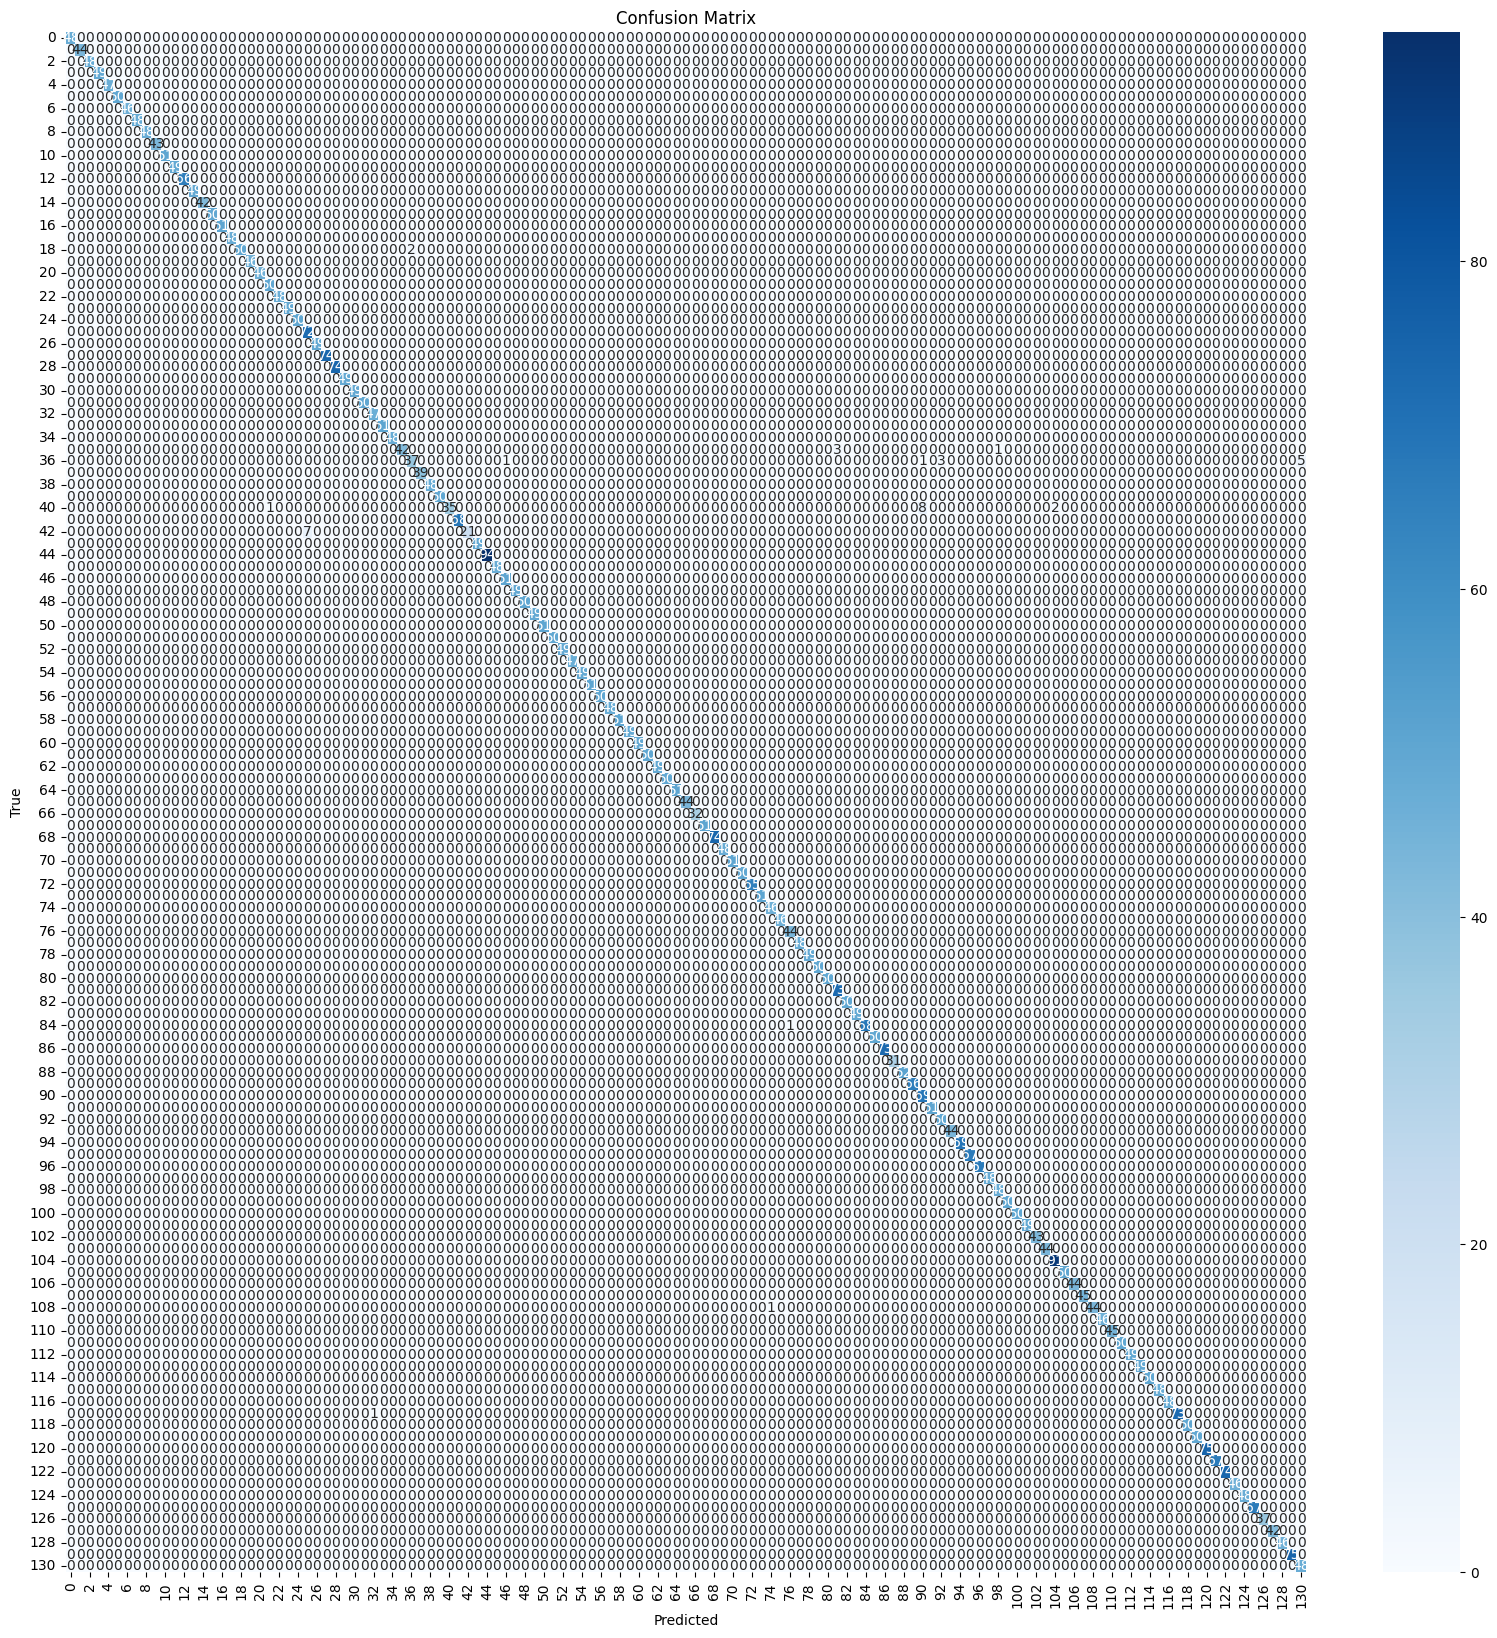

In [18]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [19]:
# Calculate precision, recall, and F1 score for each class
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
f1 = f1_score(y_true, y_pred, average=None)

# Print precision, recall, and F1 score for each class
for i in range(81):
    print(f"Class {i}: Precision: {precision[i]}, Recall: {recall[i]}, F1 Score: {f1[i]}")

Class 0: Precision: 1.0, Recall: 1.0, F1 Score: 1.0
Class 1: Precision: 1.0, Recall: 1.0, F1 Score: 1.0
Class 2: Precision: 1.0, Recall: 1.0, F1 Score: 1.0
Class 3: Precision: 1.0, Recall: 1.0, F1 Score: 1.0
Class 4: Precision: 1.0, Recall: 1.0, F1 Score: 1.0
Class 5: Precision: 1.0, Recall: 1.0, F1 Score: 1.0
Class 6: Precision: 1.0, Recall: 1.0, F1 Score: 1.0
Class 7: Precision: 1.0, Recall: 1.0, F1 Score: 1.0
Class 8: Precision: 1.0, Recall: 1.0, F1 Score: 1.0
Class 9: Precision: 1.0, Recall: 1.0, F1 Score: 1.0
Class 10: Precision: 1.0, Recall: 1.0, F1 Score: 1.0
Class 11: Precision: 1.0, Recall: 1.0, F1 Score: 1.0
Class 12: Precision: 1.0, Recall: 1.0, F1 Score: 1.0
Class 13: Precision: 1.0, Recall: 1.0, F1 Score: 1.0
Class 14: Precision: 1.0, Recall: 1.0, F1 Score: 1.0
Class 15: Precision: 1.0, Recall: 1.0, F1 Score: 1.0
Class 16: Precision: 1.0, Recall: 1.0, F1 Score: 1.0
Class 17: Precision: 1.0, Recall: 1.0, F1 Score: 1.0
Class 18: Precision: 1.0, Recall: 0.9615384615384616, F1

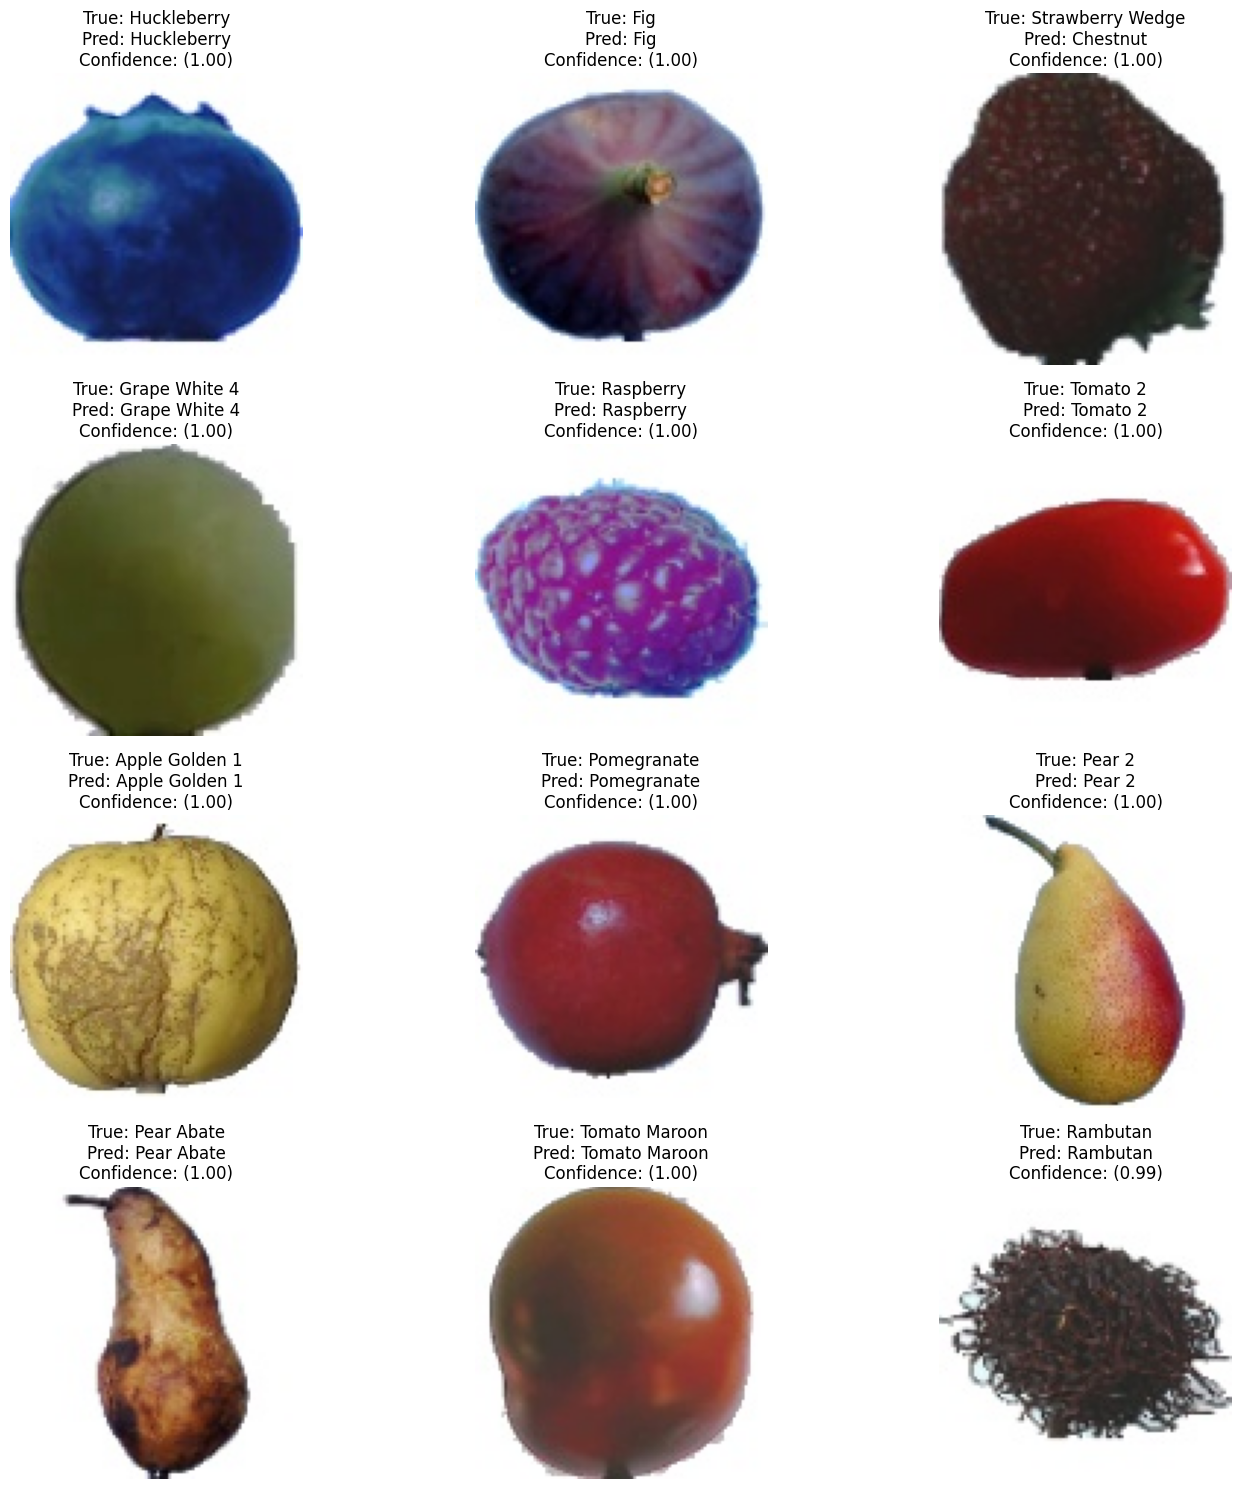

In [20]:
# Displaying sample images with predictions
def plot_sample_images(images, true_labels, predicted_labels, confidence_scores, class_names, num_samples=12):
    plt.figure(figsize=(15, 15))
    indices = np.random.choice(range(len(images)), num_samples, replace=False)
    for i, idx in enumerate(indices):
        plt.subplot(4, 3, i + 1)
        plt.imshow(images[idx])
        true_label = class_names[true_labels[idx]]
        predicted_label = class_names[predicted_labels[idx]]
        confidence = confidence_scores[idx]
        plt.title(f"True: {true_label}\nPred: {predicted_label}\nConfidence: ({confidence:.2f})")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Plot the sample images
plot_sample_images(
    all_test_images,
    y_true,
    y_pred,
    confidence_scores,
    class_names,
    num_samples=12
)

In [14]:
# Collect all images and labels from the test dataset
all_test_images = []
all_test_labels = []
count = 1
for images, labels in test_ds_131:
    all_test_images.extend(images.numpy())
    all_test_labels.extend(labels.numpy())
    count += 1
    if count > len(test_data_131):
        break
print("Done")
all_test_images = np.array(all_test_images)
all_test_labels = np.array(all_test_labels)

Done


In [16]:
# Predict on the entire test dataset at once
predictions = my_weighted_skip_131_model.predict(all_test_images, verbose=0)
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(all_test_labels, axis=1)
confidence_scores = np.max(predictions, axis=1)

# THE END